In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import air, tune
from ray.tune.schedulers import ASHAScheduler

/Users/jpgard/Documents/github/tablebench/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Ray Tune Example

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [ ]:

# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [ ]:
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [ ]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
)
results = tuner.fit()

In [ ]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

# Tablebench example

In [2]:
# extra imports for tablebench example
import rtdl
from tablebench.core import TabularDataset, TabularDatasetConfig

from tablebench.datasets.experiment_configs import EXPERIMENT_CONFIGS
from tablebench.models import get_estimator

In [3]:
experiment = "adult"
expt_config = EXPERIMENT_CONFIGS[experiment]

In [4]:
dataset_config = TabularDatasetConfig()
dset = TabularDataset(experiment,
                      config=dataset_config,
                      splitter=expt_config.splitter,
                      grouper=expt_config.grouper,
                      preprocessor_config=expt_config.preprocessor_config,
                      **expt_config.tabular_dataset_kwargs)
train_loader = dset.get_dataloader("train", 512)
loaders = {s: dset.get_dataloader(s, 2048) for s in ("validation", "test")}

[DEBUG] not downloading https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data; exists at tmp/adult.data
[DEBUG] not downloading https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names; exists at tmp/adult.names
[DEBUG] not downloading https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test; exists at tmp/adult.test
[DEBUG] dropping data columns not in FeatureList: ['fnlwgt']
[DEBUG] checking feature Age
[DEBUG] casting feature Age from dtype int64 to dtype float
[DEBUG] checking feature Workclass
[DEBUG] casting feature Workclass from dtype object to dtype CategoricalDtype
[DEBUG] checking feature Education-Num
[DEBUG] casting feature Education-Num from dtype int64 to dtype CategoricalDtype
[DEBUG] checking feature Marital Status
[DEBUG] casting feature Marital Status from dtype object to dtype CategoricalDtype
[DEBUG] checking feature Occupation
[DEBUG] casting feature Occupation from dtype object to dtype CategoricalDtype
[D

In [5]:
def train_adult(config):
    loss_fn = F.binary_cross_entropy_with_logits
    
    
    model = get_estimator("mlp", d_in=dset.X_shape[1], d_layers=[config["d_hidden"]] * config["num_layers"])
    optimizer = (
        model.make_default_optimizer()
        if isinstance(model, rtdl.FTTransformer)
        else torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]))
    
    # Fit the model; results on validation split are reported to tune.
    model.fit(train_loader, optimizer, loss_fn, n_epochs=5, other_loaders=loaders, tune_report_split="validation")

In [6]:
search_space = {
    # Sample a float uniformly between 0.0001 and 0.1, while
    # sampling in log space and rounding to multiples of 0.00005
    "lr": tune.qloguniform(1e-4, 1e-1, 5e-5),
    
    # Sample a float uniformly between 0 and 1,
    # rounding to multiples of 0.1
    "weight_decay": tune.quniform(0., 1., 0.1),
    
    # Random integer between 1 and 4
    "num_layers": tune.randint(1,4),
    
    # Random integer from set
    "d_hidden": tune.choice([64, 128, 256, 512])
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`


tuner = tune.Tuner(
    train_adult,
    param_space=search_space,
    tune_config=tune.tune_config.TuneConfig(num_samples=10),
)
results = tuner.fit()

2022-11-17 18:23:55,817	INFO worker.py:1528 -- Started a local Ray instance.
2022-11-17 18:23:57,485	WARNING function_trainable.py:586 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


2022-11-17 18:24:13,079	WARNING worker.py:1839 -- Warning: The actor ImplicitFunc is very large (58 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(train_adult pid=15041) Epoch 001 train score: 0.8578 | validation score: 0.8551 | test score: 0.8569


2022-11-17 18:24:31,466	WARNING util.py:244 -- The `start_trial` operation took 1.248 s, which may be a performance bottleneck.


(train_adult pid=15049) Epoch 001 train score: 0.7592 | validation score: 0.7592 | test score: 0.7638


2022-11-17 18:24:38,505	WARNING util.py:244 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


(train_adult pid=15052) Epoch 001 train score: 0.8566 | validation score: 0.8558 | test score: 0.8565


Trial name,_metric,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_adult_e9b87_00000,0.860091,2022-11-17_18-24-58,True,,3397650f8e4c4af486c7fdfd6704563a,"0_d_hidden=256,lr=0.0043,num_layers=3,weight_decay=0.2000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15041,35.6371,3.77549,35.6371,1668727498,0,,5,e9b87_00000,0.0147498
train_adult_e9b87_00001,0.843631,2022-11-17_18-24-52,True,,854aaed0b04a49e8ad63565bc107d260,"1_d_hidden=64,lr=0.0002,num_layers=3,weight_decay=0.3000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15049,22.4472,2.12132,22.4472,1668727492,0,,5,e9b87_00001,0.00596285
train_adult_e9b87_00002,0.846702,2022-11-17_18-24-52,True,,caaf4b5a69f24fedb3ccf78522f1424b,"2_d_hidden=64,lr=0.0261,num_layers=2,weight_decay=0.6000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15052,15.1238,2.06934,15.1238,1668727492,0,,5,e9b87_00002,0.00338006
train_adult_e9b87_00003,0.853949,2022-11-17_18-24-55,True,,137f7fa66d844e90bc4461828a1e0ae9,"3_d_hidden=256,lr=0.0181,num_layers=1,weight_decay=0.9000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15055,11.3044,2.46227,11.3044,1668727495,0,,5,e9b87_00003,0.00364208
train_adult_e9b87_00004,0.8553,2022-11-17_18-25-05,True,,caaf4b5a69f24fedb3ccf78522f1424b,"4_d_hidden=128,lr=0.0022,num_layers=3,weight_decay=0.5000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15052,12.9005,2.56472,12.9005,1668727505,0,,5,e9b87_00004,0.00338006
train_adult_e9b87_00005,0.853335,2022-11-17_18-25-14,True,,854aaed0b04a49e8ad63565bc107d260,"5_d_hidden=512,lr=0.0496,num_layers=2,weight_decay=0.4000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15049,21.3789,3.52883,21.3789,1668727514,0,,5,e9b87_00005,0.00596285
train_adult_e9b87_00006,0.857389,2022-11-17_18-25-06,True,,137f7fa66d844e90bc4461828a1e0ae9,"6_d_hidden=256,lr=0.0116,num_layers=1,weight_decay=0.3000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15055,11.3254,2.13287,11.3254,1668727506,0,,5,e9b87_00006,0.00364208
train_adult_e9b87_00007,0.85874,2022-11-17_18-25-10,True,,3397650f8e4c4af486c7fdfd6704563a,"7_d_hidden=128,lr=0.0108,num_layers=3,weight_decay=0.7000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15041,12.0153,2.07337,12.0153,1668727510,0,,5,e9b87_00007,0.0147498
train_adult_e9b87_00008,0.860705,2022-11-17_18-25-16,True,,caaf4b5a69f24fedb3ccf78522f1424b,"8_d_hidden=256,lr=0.0010,num_layers=2,weight_decay=0.3000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15052,10.7025,1.42598,10.7025,1668727516,0,,5,e9b87_00008,0.00338006
train_adult_e9b87_00009,0.855792,2022-11-17_18-25-15,True,,137f7fa66d844e90bc4461828a1e0ae9,"9_d_hidden=512,lr=0.0008,num_layers=1,weight_decay=0.3000",Joshuas-MacBook-Pro-10.local,5,127.0.0.1,15055,9.30294,1.28059,9.30294,1668727515,0,,5,e9b87_00009,0.00364208


(train_adult pid=15049) Epoch 002 train score: 0.7633 | validation score: 0.7642 | test score: 0.7683
(train_adult pid=15052) Epoch 002 train score: 0.8562 | validation score: 0.8536 | test score: 0.8546
(train_adult pid=15055) Epoch 001 train score: 0.8532 | validation score: 0.8553 | test score: 0.8517
(train_adult pid=15041) Epoch 002 train score: 0.8584 | validation score: 0.8538 | test score: 0.8528
(train_adult pid=15052) Epoch 003 train score: 0.8550 | validation score: 0.8524 | test score: 0.8531
(train_adult pid=15049) Epoch 003 train score: 0.7652 | validation score: 0.7658 | test score: 0.7701
(train_adult pid=15055) Epoch 002 train score: 0.8557 | validation score: 0.8547 | test score: 0.8541
(train_adult pid=15052) Epoch 004 train score: 0.8582 | validation score: 0.8543 | test score: 0.8557
(train_adult pid=15049) Epoch 004 train score: 0.8191 | validation score: 0.8193 | test score: 0.8201
(train_adult pid=15055) Epoch 003 train score: 0.8555 | validation score: 0.8548 |

2022-11-17 18:25:16,352	INFO tune.py:777 -- Total run time: 78.87 seconds (77.27 seconds for the tuning loop).


(train_adult pid=15052) Epoch 005 train score: 0.8639 | validation score: 0.8607 | test score: 0.8554


In [7]:
results[0].metrics_dataframe

,_metric,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time
0,0.855055,1.909721,False,NaN,NaN,1,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-24,1668727464,1.909721,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,1.909721,0,1,0.01475
1,0.853826,23.305819,False,NaN,NaN,2,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-47,1668727487,25.215540,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,25.215540,0,2,0.01475
2,0.858126,3.475073,False,NaN,NaN,3,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-51,1668727491,28.690613,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,28.690613,0,3,0.01475
3,0.857020,3.170955,False,NaN,NaN,4,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-54,1668727494,31.861568,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,31.861568,0,4,0.01475
4,0.860091,3.775488,False,NaN,NaN,5,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-58,1668727498,35.637056,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,35.637056,0,5,0.01475


[<AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >]

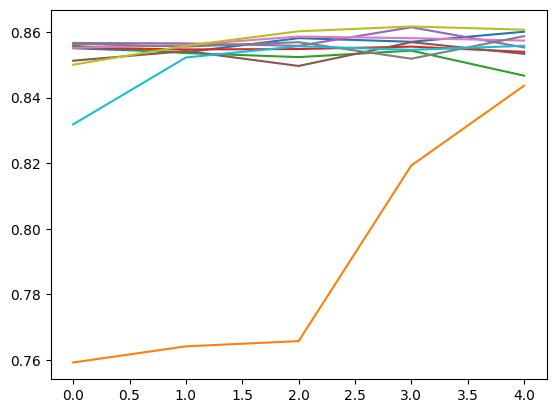

In [11]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d._metric.plot() for d in dfs.values()]

In [10]:
list(dfs.values())[0]

,_metric,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time
0,0.855055,1.909721,False,NaN,NaN,1,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-24,1668727464,1.909721,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,1.909721,0,1,0.01475
1,0.853826,23.305819,False,NaN,NaN,2,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-47,1668727487,25.215540,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,25.215540,0,2,0.01475
2,0.858126,3.475073,False,NaN,NaN,3,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-51,1668727491,28.690613,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,28.690613,0,3,0.01475
3,0.857020,3.170955,False,NaN,NaN,4,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-54,1668727494,31.861568,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,31.861568,0,4,0.01475
4,0.860091,3.775488,False,NaN,NaN,5,e9b87_00000,3397650f8e4c4af486c7fdfd6704563a,2022-11-17_18-24-58,1668727498,35.637056,15041,Joshuas-MacBook-Pro-10.local,127.0.0.1,35.637056,0,5,0.01475
